# **Test on the capabilities of our model** 🏋

In [1]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random
import jax
import matplotlib.pyplot as plt
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use('science')

## Test the purely raw model

In [2]:
state_variables = 2
expected_number_of_nls = 2
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

model = ZeroLayersNN(N=input_dim, L=expected_number_of_nls, output_dim=state_variables)
seed = 42
batch_size = 32


dummy_input = jnp.zeros((batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

Then we create the random non linearities:

- **generate_alphabeta**: This function generates orthonormal basis vectors using QR decomposition. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of basis vectors), and `seed` (a seed for random number generation). The function creates a random matrix `A` of shape `(dim, num)` and then performs QR decomposition on `A` to obtain an orthonormal matrix `Q`. The function returns `Q`.
- **generate_callable_functions**: This function generates a set of callable functions based on the orthonormal basis vectors generated by `generate_alphabeta`. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of functions to generate), and `seed` (a seed for random number generation). The function splits the basis vectors into three parts: `alphas`, `betas`, and `gammas`. It then defines a nested function `make_function` that creates a callable function using these vectors. The `make_function` uses JAX's `jit` decorator to compile the function for faster execution. The main function returns a tuple containing the generated functions and the transposed basis vectors.

In [3]:
def generate_alphabeta(dim, num, seed):

    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    Q, _ = jnp.linalg.qr(A)
    return Q * 10

def generate_callable_functions(dim, num, seed):

    bases = generate_alphabeta(dim, num, seed)  # Get num basis vectors
   
    alphas = bases[:dim//2, :].T  # First half of Q are alphas
    gammas = bases[dim//2:, :].T

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (alpha[0] * nn.relu(x + gamma[0]) +
                    alpha[1] * nn.relu(x + gamma[1]) +
                    alpha[2] * nn.relu(x + gamma[2]))
        return func
    
    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases.T

Now we want to work with the simplest case possible.


In [4]:
dims = 6
n_nls = 2
alphagamma = generate_alphabeta(dims, n_nls, seed)
alphas = alphagamma[:dims//2, :].T  # First half of Q are alphas
gammas = alphagamma[dims//2:, :].T
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 1),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed
}

Alphas: [[-1.85333055 -6.60290317  5.68947106]
 [ 4.64605079 -4.92323169 -0.98039673]]
Gammas: [[ 2.93265932 -0.8081216  -3.36796725]
 [ 1.68994228  3.78551475  6.00239929]]


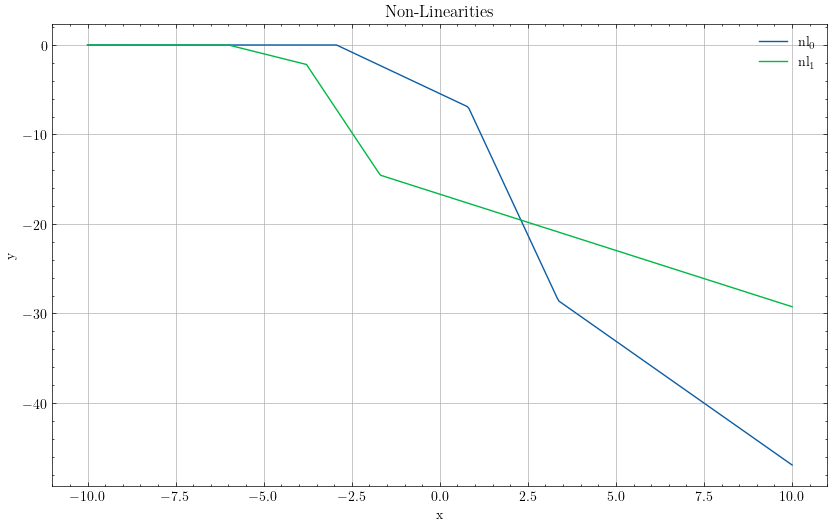

In [5]:
x = jnp.linspace(-10, 10, 400)

# Plot each callable's result
plt.figure(figsize=(10, 6))
i = 0
for func in non_lins:
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i)
    i += 1

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-Linearities')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.clf()
plt.close()

In [6]:
save_dir = "Data"
filename = "Test"

system = Equations(**config)
system.save_symb_expr(filename=os.path.join(save_dir, filename+'_symbolic.pdf'))

PDF already exists


### Linspace

Let's try to train the model with data sampled by linspace. The test set is taken out of bounds with respect to the training data, in such way it is possible to verify the generalization abilities of the model.

In [7]:
def my_eval(v):
    return system(y=v)

In [8]:
bound = 15
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config['n_eqs']))

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(subkey, total_size, shape=(test_size,), replace=False)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size//2)
range2 = jnp.linspace(bound, bound + 5, test_size//2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config['n_eqs']))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate
evaluated_values = vmap(my_eval)(values)

In [9]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)

(10000, 2) (2000, 2) (2000, 2)


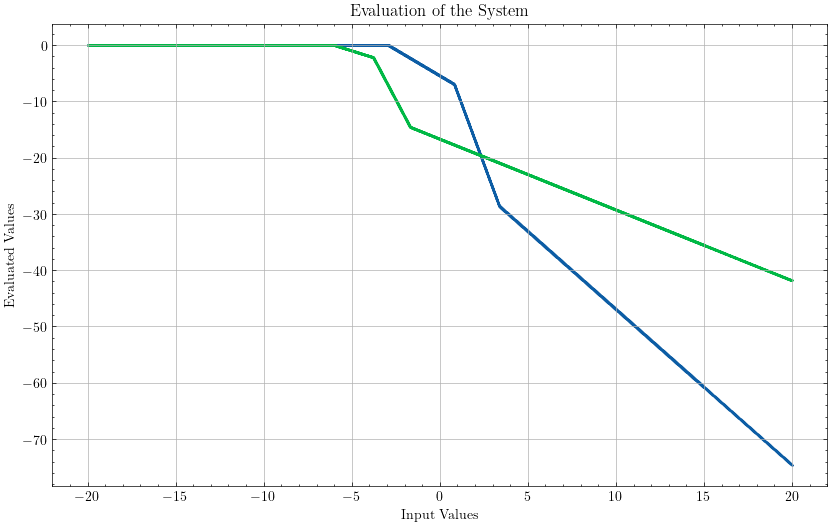

In [10]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=0.1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [11]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, batch_size)

In [12]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)
print(len(train_batches), len(inbound_test_batches), len(outofbound_test_batches))

(10000, 4) (2000, 4) (2000, 4)
312 62 62


In [13]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T
print(vectors)

[[ 0.11888107  3.0801459   0.35667498 -1.8024799  -0.27054141  0.69889927]
 [-0.68315992  1.4068019   0.44821055 -0.54813382 -0.84782363 -0.81188731]]


In [14]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:

        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        inbound_test_loss = evaluate(state, inbound_test_batches)
        outofbound_test_loss = evaluate(state, outofbound_test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, "
              f"Inbound Test Loss: {inbound_test_loss/len(inbound_test_batches)}, Out-of-bound Test Loss: {outofbound_test_loss/len(outofbound_test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 148.87903253803293, Inbound Test Loss: 0.8783353816776238, Out-of-bound Test Loss: 1.1371930105398829
Epoch 2, Loss: 32.66657597850159, Inbound Test Loss: 0.47484353211752317, Out-of-bound Test Loss: 1.1073817541775055
Epoch 4, Loss: 24.642752174062032, Inbound Test Loss: 0.35434761472558207, Out-of-bound Test Loss: 0.799652271059998
Epoch 6, Loss: 18.046152796884897, Inbound Test Loss: 0.2571041561063877, Out-of-bound Test Loss: 0.5082795986465084
Epoch 8, Loss: 12.985725801549377, Inbound Test Loss: 0.1857679347240726, Out-of-bound Test Loss: 0.25338623681823474
Epoch 10, Loss: 9.961580441102699, Inbound Test Loss: 0.14584593795022713, Out-of-bound Test Loss: 0.10333280684098982
Epoch 12, Loss: 8.288368848140253, Inbound Test Loss: 0.12215261236475154, Out-of-bound Test Loss: 0.03463339162328291
Epoch 14, Loss: 7.150321411990513, Inbound Test Loss: 0.1066901507954156, Out-of-bound Test Loss: 0.025880707483133716
Epoch 16, Loss: 6.539413577297415, Inbound Test Loss: 0.0

In [15]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T
print(vectors)

[[-3.2419833   3.76207087  1.05595514 -3.36782349 -0.80827239  2.93294832]
 [-1.16259305  1.89341537 -0.2980977   1.60526313  4.25458121  1.61269502]]


[Array(1, dtype=int64), Array(1, dtype=int64)]


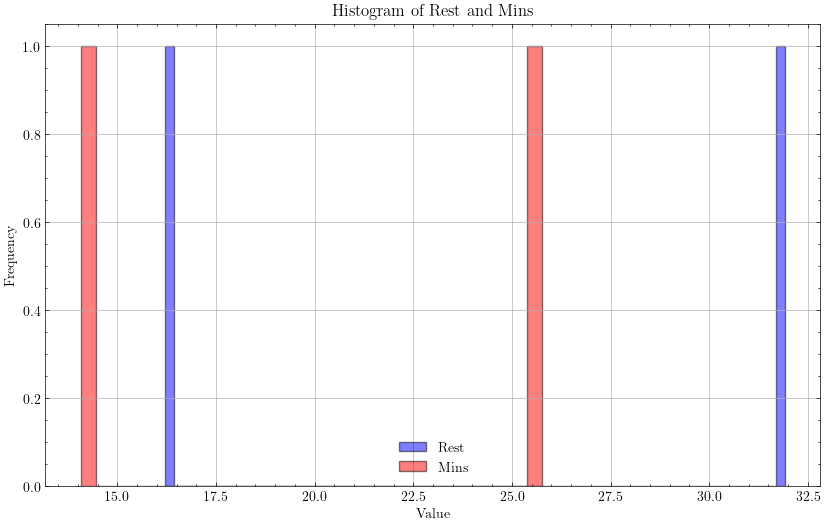

In [16]:
rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=70, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=30, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

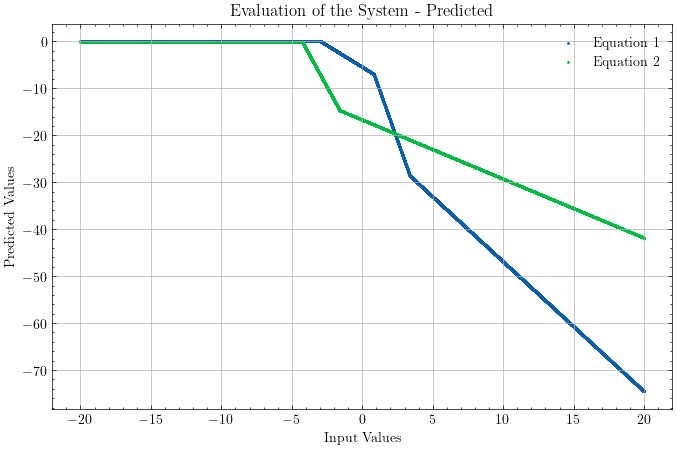

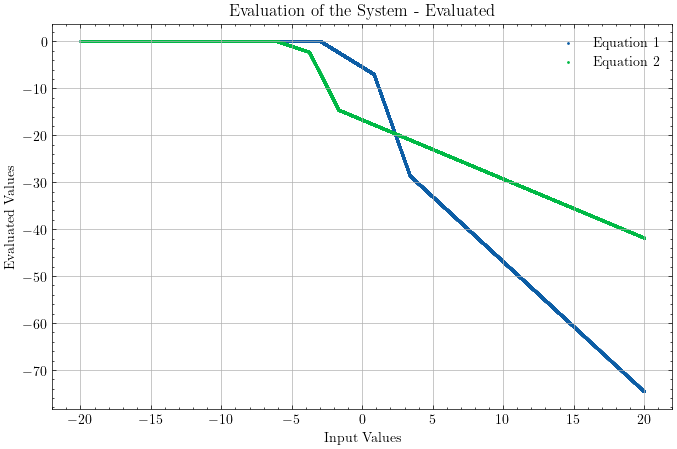

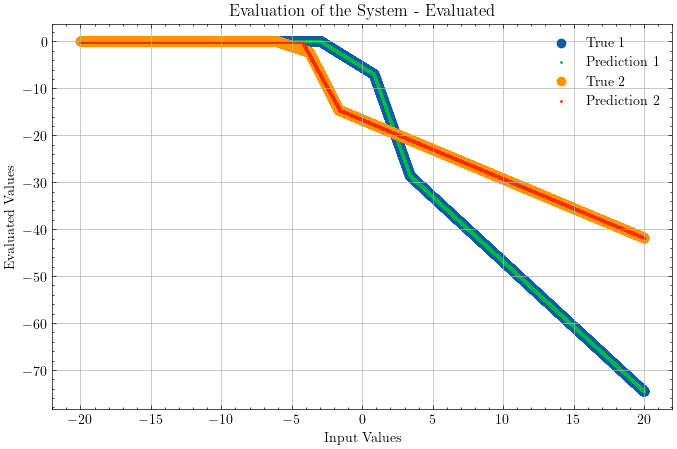

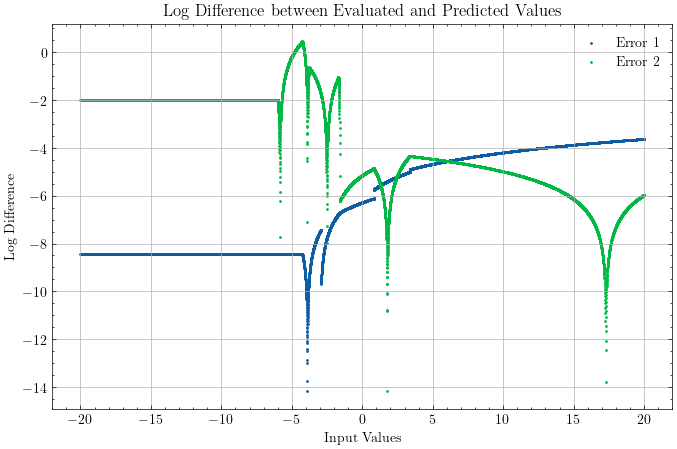

In [17]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'True {i+1}')
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Prediction {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i]) + 1e-7), label=f'Error {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Log Difference')
plt.title('Log Difference between Evaluated and Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

plt.clf()
plt.close()


In [30]:
print(state.params['params']['output_layer']['kernel'])
print(vec_nls)
print(vectors)

[[ 1.6284763e-04 -4.4116210e-03]
 [ 7.4522090e-05  2.1421060e-04]
 [-7.9930294e-04  2.1684272e+00]
 [ 2.3436661e+00  2.2021977e-02]]
[[-1.85333055 -6.60290317  5.68947106  2.93265932 -0.8081216  -3.36796725]
 [ 4.64605079 -4.92323169 -0.98039673  1.68994228  3.78551475  6.00239929]]
[[ 1.93117891 -2.48698155 -0.01630179  1.59159076  4.28870106 -4.45279463]
 [-2.81781851  2.42817533 -0.79127782 -0.80840021 -3.36767372  2.93483787]]


### Uniform

In [19]:
system = Equations(**config)

In [ ]:
# Split random key
key, subkey = random.split(key)

# Generate new training values uniformly in [-bound, bound]
train_values = random.uniform(subkey, shape=(total_size, config['n_vars']), minval=-1 * bound, maxval=bound)

inbound_test = train_values[indices]  # Extract test points
train_values = train_values[mask]  # Remove them from training set

# Generate out-of-bound test values in [-bound-bound_delta, -bound] ∪ [bound, bound+bound_delta]
bound_delta = 5
key, subkey = random.split(key)
range1 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=-1*bound - bound_delta, maxval=-1*bound)
key, subkey = random.split(key)
range2 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=bound, maxval=bound + bound_delta)
outofbound_test = jnp.concatenate((range1, range2), axis=0)

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate training and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate function on all values
evaluated_values = vmap(my_eval)(values)

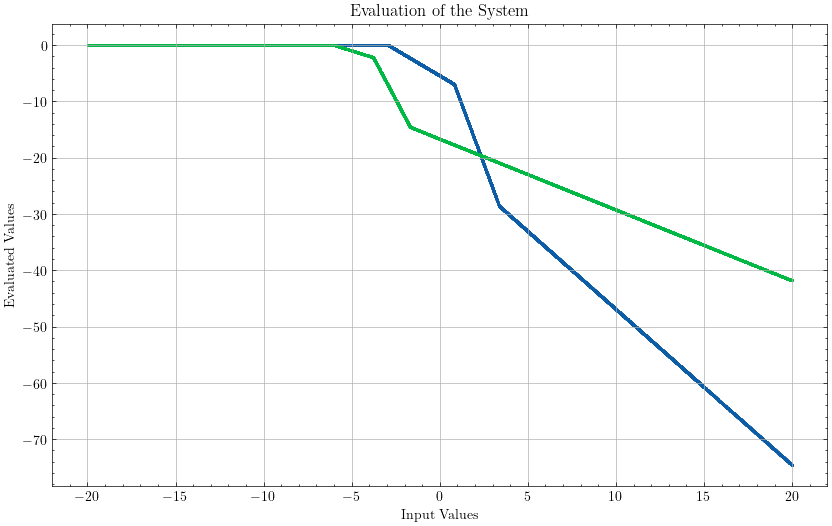

In [21]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [22]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, batch_size)

In [23]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [24]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:

        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        inbound_test_loss = evaluate(state, inbound_test_batches)
        outofbound_test_loss = evaluate(state, outofbound_test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, "
              f"Inbound Test Loss: {inbound_test_loss/len(inbound_test_batches)}, Out-of-bound Test Loss: {outofbound_test_loss/len(outofbound_test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 682.8486060911439, Inbound Test Loss: 9.268940275595172, Out-of-bound Test Loss: 24.01155955262787
Epoch 2, Loss: 297.01362620614094, Inbound Test Loss: 3.0292085474842, Out-of-bound Test Loss: 3.3433590402809785
Epoch 4, Loss: 34.36221925465639, Inbound Test Loss: 0.4100809227093601, Out-of-bound Test Loss: 1.3830386313680478
Epoch 6, Loss: 21.547866674559153, Inbound Test Loss: 0.33933950167435517, Out-of-bound Test Loss: 1.162536972771776
Epoch 8, Loss: 18.295285498984487, Inbound Test Loss: 0.28557684196679384, Out-of-bound Test Loss: 0.9034036557302118
Epoch 10, Loss: 15.200069791190941, Inbound Test Loss: 0.23541979970815752, Out-of-bound Test Loss: 0.6633789984428854
Epoch 12, Loss: 12.289869924685416, Inbound Test Loss: 0.18846128703749687, Out-of-bound Test Loss: 0.44852083037918383
Epoch 14, Loss: 9.49075374525165, Inbound Test Loss: 0.14289728055283893, Out-of-bound Test Loss: 0.26080753301955184
Epoch 16, Loss: 6.759046629546469, Inbound Test Loss: 0.09946969

[Array(1, dtype=int64), Array(1, dtype=int64)]


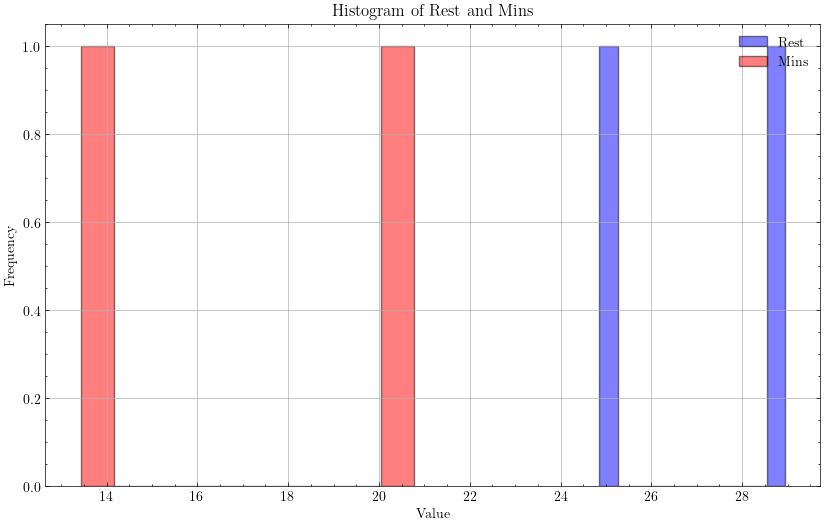

In [ ]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T

rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=10, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=10, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
print(vectors)
print(vec_nls)

[[ 1.93117891 -2.48698155 -0.01630179  1.59159076  4.28870106 -4.45279463]
 [-2.81781851  2.42817533 -0.79127782 -0.80840021 -3.36767372  2.93483787]]
[[-1.85333055 -6.60290317  5.68947106  2.93265932 -0.8081216  -3.36796725]
 [ 4.64605079 -4.92323169 -0.98039673  1.68994228  3.78551475  6.00239929]]


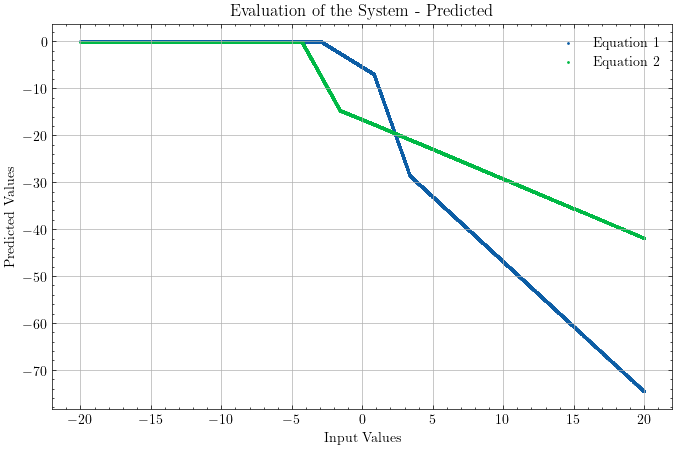

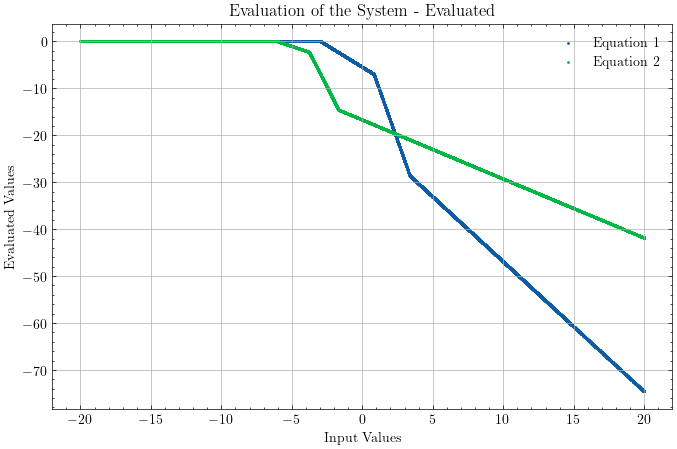

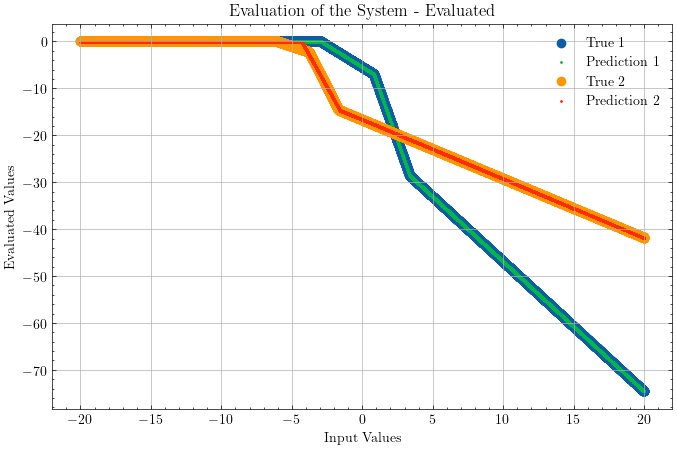

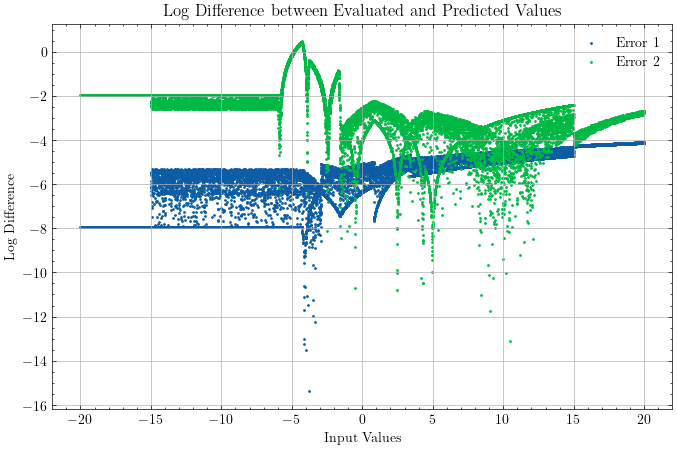

In [27]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'True {i+1}')
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Prediction {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i]) + 1e-7), label=f'Error {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Log Difference')
plt.title('Log Difference between Evaluated and Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

plt.clf()
plt.close()


In [28]:
print(state.params['params']['output_layer']['kernel'])


[[ 1.6284763e-04 -4.4116210e-03]
 [ 7.4522090e-05  2.1421060e-04]
 [-7.9930294e-04  2.1684272e+00]
 [ 2.3436661e+00  2.2021977e-02]]
